In [1]:
import dask.dataframe as dd
import  pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import time
import gc 

In [2]:
# start_time = time.time()
# train= pd.read_csv('/home/carlchao/Riiid/data/train.csv',
#                 usecols=[1, 2, 3,4,7,8,9], dtype={'timestamp': 'int64', 'user_id': 'int32' ,'content_id': 'int16','content_type_id': 'int8','answered_correctly':'int8','prior_question_elapsed_time': 'float32','prior_question_had_explanation': 'int8'})
# # train= pd.read_csv('/home/carlchao/Riiid/data/train.csv')
# print("pandas took %s seconds" % (time.time() - start_time))
# # train = train[train.content_type_id == False]

In [3]:
# !pip install datatable
import datatable as dt
start_time = time.time()
X = dt.fread('/home/carlchao/Riiid_data/data/train.csv')
X = X.to_pandas()
print("datatable took %s seconds" % (time.time() - start_time))



datatable took 7.8492348194122314 seconds


In [4]:
print(X.shape)

(101230332, 10)


In [5]:
X = X.sort_values(['timestamp'], ascending=True)

X.drop(['timestamp','content_type_id'], axis=1,   inplace=True)

# results_c = X[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
# results_c.columns = ["answered_correctly_content"]

# results_u = X[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum'])
# results_u.columns = ["answered_correctly_user", 'sum']

In [6]:
#reading in question df
questions_df = pd.read_csv('/home/carlchao/Riiid_data/data/questions.csv',
                            usecols=[0,1, 3,4],
                            dtype={'question_id': 'int16',
                              'part': 'int8','bundle_id': 'int8','tags': 'str'}
                          )
tag = questions_df["tags"].str.split(" ", n = 10, expand = True) 
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']

questions_df =  pd.concat([questions_df,tag],axis=1)
questions_df['tags1'] = pd.to_numeric(questions_df['tags1'], errors='coerce')
questions_df['tags2'] = pd.to_numeric(questions_df['tags2'], errors='coerce')
questions_df['tags3'] = pd.to_numeric(questions_df['tags3'], errors='coerce')
questions_df['tags4'] = pd.to_numeric(questions_df['tags4'], errors='coerce')
questions_df['tags5'] = pd.to_numeric(questions_df['tags5'], errors='coerce')
questions_df['tags6'] = pd.to_numeric(questions_df['tags6'], errors='coerce')

In [7]:
X = X.iloc[:8000000].copy()
X['prior_question_had_explanation'].fillna(False, inplace=True)
# X = pd.merge(X, results_u, on=['user_id'], how="left")
# X = pd.merge(X, results_c, on=['content_id'], how="left")
X = pd.merge(X, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

X=X[X.answered_correctly!= -1 ]
X=X.sort_values(['user_id'])
Y = X[["answered_correctly"]]
X = X.drop(["answered_correctly"], axis=1)

In [8]:
print(X.shape)

(7987187, 17)


In [9]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])
# X.head()

# X = X[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc','tags1','tags2','tags3']]
X = X[['bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc','tags1','tags2','tags3']] 
X.fillna(0.5,  inplace=True)
from  sklearn.tree import DecisionTreeClassifier
from  sklearn.model_selection import train_test_split
Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size =0.2, shuffle=False, random_state=2020)

import lightgbm as lgb

params = {
    'objective': 'binary',
    'max_bin': 600,
    'learning_rate': 0.02,
    'num_leaves': 80
}


lgb_train = lgb.Dataset(Xt, Yt,categorical_feature = ['part','tags1','tags2','tags3'])
lgb_eval = lgb.Dataset(Xv, Yv, reference=lgb_train,categorical_feature = ['part','tags1','tags2','tags3'])

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=10000,
    early_stopping_rounds=10,
    categorical_feature = ['part','tags1','tags2','tags3']
)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.672731	valid_1's binary_logloss: 0.672787
[20]	training's binary_logloss: 0.658748	valid_1's binary_logloss: 0.658846
[30]	training's binary_logloss: 0.64897	valid_1's binary_logloss: 0.649098
[40]	training's binary_logloss: 0.641923	valid_1's binary_logloss: 0.642091
[50]	training's binary_logloss: 0.636922	valid_1's binary_logloss: 0.637133
[60]	training's binary_logloss: 0.63329	valid_1's binary_logloss: 0.63353
[70]	training's binary_logloss: 0.630621	valid_1's binary_logloss: 0.630882
[80]	training's binary_logloss: 0.628637	valid_1's binary_logloss: 0.628911
[90]	training's binary_logloss: 0.627113	valid_1's binary_logloss: 0.627401
[100]	training's binary_logloss: 0.625944	valid_1's binary_logloss: 0.626249
[110]	training's binary_logloss: 0.625011	valid_1's binary_logloss: 0.625331
[120]	training's binary_logloss: 0.624248	valid_1's binary_logloss: 0.624581
[130]	training's binary_log

[1070]	training's binary_logloss: 0.611845	valid_1's binary_logloss: 0.613
[1080]	training's binary_logloss: 0.611809	valid_1's binary_logloss: 0.612974
[1090]	training's binary_logloss: 0.61176	valid_1's binary_logloss: 0.612931
[1100]	training's binary_logloss: 0.611707	valid_1's binary_logloss: 0.612888
[1110]	training's binary_logloss: 0.611663	valid_1's binary_logloss: 0.61285
[1120]	training's binary_logloss: 0.611618	valid_1's binary_logloss: 0.612813
[1130]	training's binary_logloss: 0.611563	valid_1's binary_logloss: 0.612765
[1140]	training's binary_logloss: 0.611509	valid_1's binary_logloss: 0.612718
[1150]	training's binary_logloss: 0.611462	valid_1's binary_logloss: 0.612678
[1160]	training's binary_logloss: 0.611439	valid_1's binary_logloss: 0.612663
[1170]	training's binary_logloss: 0.6114	valid_1's binary_logloss: 0.612633
[1180]	training's binary_logloss: 0.611365	valid_1's binary_logloss: 0.612605
[1190]	training's binary_logloss: 0.611336	valid_1's binary_logloss: 0.

[2130]	training's binary_logloss: 0.608971	valid_1's binary_logloss: 0.610905
[2140]	training's binary_logloss: 0.608953	valid_1's binary_logloss: 0.610895
[2150]	training's binary_logloss: 0.608933	valid_1's binary_logloss: 0.610883
[2160]	training's binary_logloss: 0.608917	valid_1's binary_logloss: 0.610875
[2170]	training's binary_logloss: 0.608901	valid_1's binary_logloss: 0.610867
[2180]	training's binary_logloss: 0.608886	valid_1's binary_logloss: 0.610858
[2190]	training's binary_logloss: 0.60887	valid_1's binary_logloss: 0.610849
[2200]	training's binary_logloss: 0.608854	valid_1's binary_logloss: 0.61084
[2210]	training's binary_logloss: 0.608841	valid_1's binary_logloss: 0.610834
[2220]	training's binary_logloss: 0.608827	valid_1's binary_logloss: 0.610828
[2230]	training's binary_logloss: 0.608815	valid_1's binary_logloss: 0.610823
[2240]	training's binary_logloss: 0.608792	valid_1's binary_logloss: 0.610807
[2250]	training's binary_logloss: 0.608772	valid_1's binary_loglos

[3190]	training's binary_logloss: 0.607529	valid_1's binary_logloss: 0.610251
[3200]	training's binary_logloss: 0.607519	valid_1's binary_logloss: 0.610248
[3210]	training's binary_logloss: 0.607507	valid_1's binary_logloss: 0.610242
[3220]	training's binary_logloss: 0.607496	valid_1's binary_logloss: 0.610237
[3230]	training's binary_logloss: 0.607484	valid_1's binary_logloss: 0.610231
[3240]	training's binary_logloss: 0.607473	valid_1's binary_logloss: 0.610226
[3250]	training's binary_logloss: 0.607463	valid_1's binary_logloss: 0.610223
[3260]	training's binary_logloss: 0.607454	valid_1's binary_logloss: 0.610221
[3270]	training's binary_logloss: 0.607442	valid_1's binary_logloss: 0.610216
[3280]	training's binary_logloss: 0.607433	valid_1's binary_logloss: 0.610214
[3290]	training's binary_logloss: 0.607425	valid_1's binary_logloss: 0.610214
[3300]	training's binary_logloss: 0.607415	valid_1's binary_logloss: 0.610211
[3310]	training's binary_logloss: 0.607402	valid_1's binary_logl

In [10]:
y_pred = model.predict(Xv)
y_true = np.array(Yv)
roc_auc_score(y_true, y_pred)

0.7255909278547327

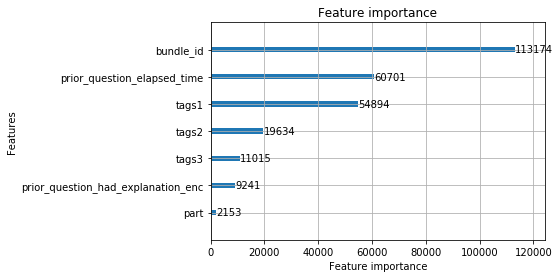

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
#displaying the most important features
lgb.plot_importance(model)
plt.show()

In [12]:
# iter_test = env.iter_test()
# for (test_df, sample_prediction_df) in iter_test:
#     test_df = test_df.sort_values(['user_id','timestamp'], ascending=False)
#     test_df['answer_time'] = test_df.groupby(['user_id'])['prior_question_elapsed_time'].shift(1)
    
#     test_df = pd.merge(test_df, results_u, on=['user_id'],  how="left")
#     test_df = pd.merge(test_df, results_c, on=['content_id'],  how="left")    
#     test_df = pd.merge(test_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')    
#     test_df['answered_correctly_user'].fillna(0.5, inplace=True)
#     test_df['answered_correctly_content'].fillna(0.5, inplace=True)
#     test_df['sum'].fillna(0, inplace=True)
#     test_df['prior_question_had_explanation'].fillna(False, inplace=True)
#     test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
#     test_df['answered_correctly'] =  model.predict(test_df[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc',
#                                                            'tags1','tags2','tags3']])
#     env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])